# 2025 CITS4012 Individual Assignment

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [2]:
%pip install spacy
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz
%pip install scispacy
%pip install gensim
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import spacy
import scispacy
import csv
import gensim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

# 1.Dataset Processing

In [4]:
def read_data(fname):
    X = []
    y = []
    with open(fname, newline='\n') as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader) # skips first row (headers)
        for row in reader:
            X.append(row[1])
            y.append(int(row[0]))

    return X, y

train_X_raw, train_y = read_data("files/medical_tc_train.csv")
test_X_raw, test_y = read_data("files/medical_tc_test.csv")
_, labels = read_data("files/medical_tc_labels.csv") 
#labels contains a list of labels, where labels[i] corresponds to value i in train_y or test_y sets

In [5]:
biomedical_nlp = spacy.load("en_core_sci_sm") #imports a biomedical scispaCy NLP model

def preprocess(X):
    preprocessed_X = []
    for p in biomedical_nlp.pipe(X, batch_size=32, n_process=4): #pipe is far faster than manual loop. Can potentially experiment with hyperparam values
        tokens=[
            token.lemma_.lower() #lemmatization, #case insensitivity
            for token in p
            if not token.is_stop and not token.is_punct #removal of stopwords and punctuation
        ]
        preprocessed_X.append(tokens)
    return preprocessed_X

train_X = preprocess(train_X_raw)
test_X = preprocess(test_X_raw)


/Users/bobbeashel/Desktop/CITS4012/Assignment 1/.venv/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]
/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/pyt

In [6]:
n_classes = max(test_y + train_y)

train_y_1hot = to_categorical(np.array(train_y) - 1, num_classes=n_classes)
test_y_1hot = to_categorical(np.array(train_y) - 1, num_classes=n_classes)

# 2.Word Embedding Construction
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [7]:
word2vec = gensim.models.Word2Vec(train_X, min_count=2) #default was 5

In [8]:
bio_wordvec_file = "files/bio_embedding_extrinsic"
bio_wordvec = gensim.models.KeyedVectors.load_word2vec_format(bio_wordvec_file, binary=True)

bio_wordvec_vectors= {}
for X_i in train_X:
    for token in X_i:
        if token in bio_wordvec.key_to_index:
            bio_wordvec_vectors[token] = bio_wordvec[token]
        #else:
            #print(token)
            # TODO
            # WHAT TO DO HERE? THIS IS MOSTLY NUMBERS, SYMBOLS AND UNITS

In [9]:
print(bio_wordvec_vectors["aspirin"])
print(word2vec.wv["aspirin"])

[ 0.65763766  0.05259445 -0.00632999  0.03316407  0.09080191  0.83068997
 -0.7846622   0.10647005 -0.16752651 -0.14556043  0.00265241 -0.4391226
 -0.01842707  0.43879074  0.19886191 -0.27617273 -0.05760117  0.00381236
  0.33310974 -0.14743805  0.30462447 -0.17140043  0.22673702  0.37815243
 -0.51076347 -0.2249445  -0.28158003  0.03232608 -0.01096186  0.02274823
  0.16291724  0.42415467 -0.01874056  0.19721873  0.238976   -0.10082288
 -0.06907111  0.17320308 -0.27078012 -0.01779107 -0.90206206 -0.4999185
  0.21059695 -0.8400637  -0.3781007   0.41125545 -0.3512852   0.59978807
  0.320518   -0.00684524 -0.45143342 -0.26656586  0.44414276 -0.18968502
 -0.4298861   0.01795534  0.13739036 -0.27767774 -0.06373292 -0.45644802
  0.03783754  0.18291944  0.41600004 -0.10658144 -0.08188083 -0.3447773
  0.5761461   0.39203626  0.2018173  -0.11694346 -0.39412752  0.39460117
  0.01699726 -0.13826968  0.172631   -0.30906424 -0.20184335  0.7515006
  0.14740397 -0.00445175 -0.2248147  -0.190953   -0.356

# 3.Visualization

In [10]:
def min_max_x_y(word2vec_transformed, biowordvec_transformed, buffer):
    all_points = np.vstack([word2vec_transformed, biowordvec_transformed])
    xmin, ymin = all_points.min(axis=0)
    xmax, ymax = all_points.max(axis=0)
    
    x_range = xmax - xmin
    y_range = ymax - ymin

    # Add [buffer]% gap on each side for aesthetic reasons only
    buffer_x = x_range * buffer
    buffer_y = y_range * buffer

    xmin = xmin - buffer_x
    xmax = xmax + buffer_x
    ymin = ymin - buffer_y
    ymax = ymax + buffer_y

    return xmin, xmax, ymin, ymax
    

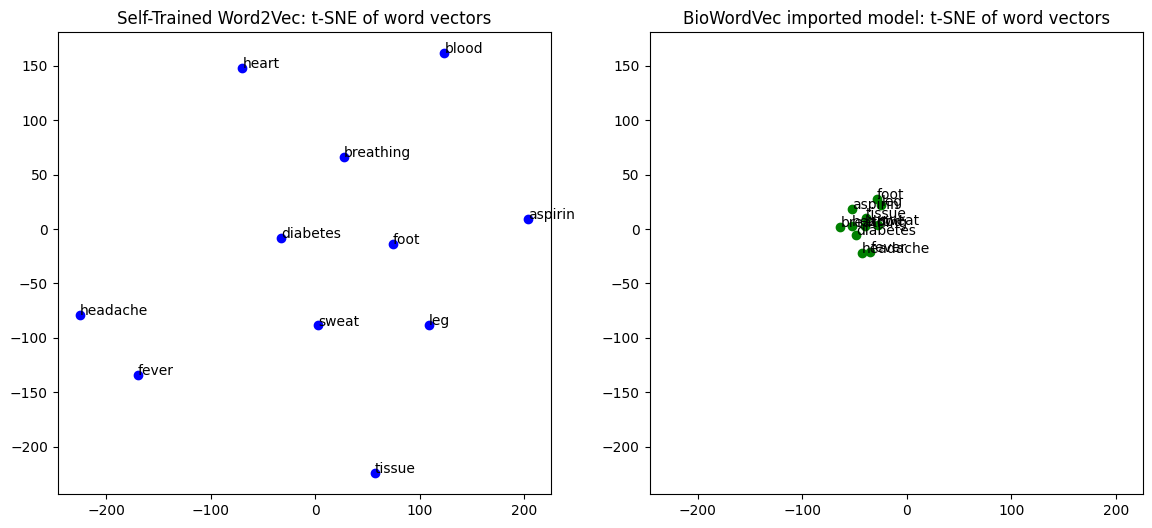

In [11]:
visualised_words = ["aspirin", "diabetes", "tissue", "blood", "heart", "breathing", "sweat", "headache", "fever", "leg", "foot"]

bio_wordvec_visualised_vecs = []
word2vec_visualised_vecs = []

for word in visualised_words:

    bio_wordvec_visualised_vecs.append(bio_wordvec[word])
    word2vec_visualised_vecs.append(word2vec.wv[word])

bio_wordvec_visualised_vecs = np.array(bio_wordvec_visualised_vecs)
word2vec_visualised_vecs = np.array(word2vec_visualised_vecs)

word2vec_transformed = TSNE(n_components=2, perplexity=5).fit_transform(word2vec_visualised_vecs)
biowordvec_transformed = TSNE(n_components=2, perplexity=5).fit_transform(bio_wordvec_visualised_vecs)

# These ensure both scales are the same
xmin, xmax, ymin, ymax = min_max_x_y(word2vec_transformed, biowordvec_transformed, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(word2vec_transformed[:,0], word2vec_transformed[:,1], color='blue')

for i, word in enumerate(visualised_words):
    axes[0].annotate(word, (word2vec_transformed[i,0], word2vec_transformed[i,1]))
axes[0].set_title("Self-Trained Word2Vec: t-SNE of word vectors")
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)

axes[1].scatter(biowordvec_transformed[:,0], biowordvec_transformed[:,1], color='green')

for i, word in enumerate(visualised_words):
    axes[1].annotate(word, (biowordvec_transformed[i,0], biowordvec_transformed[i,1]))
axes[1].set_title("BioWordVec imported model: t-SNE of word vectors")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)

plt.show()

# 3.2 Interpretation

TODO

# 4.RNN-based Model Implementation

In [12]:
#Pre-processing for RNN

max_tokens = max(len(X_i) for X_i in (train_X + test_X))

train_X_padded_w2v = np.zeros((len(train_X), max_tokens, 100))
train_X_padded_biovec = np.zeros((len(train_X), max_tokens, 200))
test_X_padded_w2v = np.zeros((len(test_X), max_tokens, 100))
test_X_padded_biovec = np.zeros((len(test_X), max_tokens, 200))

for i, paragraph in enumerate(train_X):
    for j, token in enumerate(paragraph):

        if token in word2vec.wv.key_to_index:
            train_X_padded_w2v[i, j, :] = word2vec.wv[token]

        if token in bio_wordvec.key_to_index:
            train_X_padded_biovec[i, j, :] = bio_wordvec[token]


for i, paragraph in enumerate(test_X):
    for j, token in enumerate(paragraph):

        if token in word2vec.wv.key_to_index:
            test_X_padded_w2v[i, j, :] = word2vec.wv[token]
            
        if token in bio_wordvec.key_to_index:
            test_X_padded_biovec[i, j, :] = bio_wordvec[token]


In [13]:
def build_rnn_model(max_tokens, embedding_dim, num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_tokens, embedding_dim))) # use this line to ignore all 0 values.
    model.add(LSTM(128, input_shape=(max_tokens, embedding_dim)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [16]:
model_w2v = build_rnn_model(max_tokens, 100, n_classes)
model_biowordvec = build_rnn_model(max_tokens, 200, n_classes)

model_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_biowordvec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_w2v = model_w2v.fit(train_X_padded_w2v, train_y_1hot, batch_size=32, epochs=10, validation_split=0.2)
history_biowordvec = model_biowordvec.fit(train_X_padded_biovec, train_y_1hot, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/2
289/289 ━━━━━━━━━━━━━━━━━━━━ 55s 184ms/step - accuracy: 0.4878 - loss: 1.2314 - val_accuracy: 0.5472 - val_loss: 1.1171
Epoch 2/2
289/289 ━━━━━━━━━━━━━━━━━━━━ 53s 182ms/step - accuracy: 0.5469 - loss: 1.1065 - val_accuracy: 0.5481 - val_loss: 1.0722
Epoch 1/2
289/289 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - accuracy: 0.5053 - loss: 1.2126 - val_accuracy: 0.5212 - val_loss: 1.1635
Epoch 2/2
289/289 ━━━━━━━━━━━━━━━━━━━━ 59s 203ms/step - accuracy: 0.5579 - loss: 1.0594 - val_accuracy: 0.5693 - val_loss: 1.0483


# 5.Performance Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [18]:
prob_w2v = model_w2v.predict(test_X_padded_w2v)
prob_biovec = model_biowordvec.predict(test_X_padded_biovec)

preds_w2v = np.argmax(prob_w2v, axis=1) + 1
preds_biovec = np.argmax(prob_biovec, axis=1) + 1

91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step
Word2Vec Model accuracy:  0.554016620498615
BioWordVec Model accuracy:  0.5668282548476454
Word2Vec F1 score:  1.0
BioWordVec F1 score:  0.6691350094313495


In [19]:
acc_w2v = np.mean(preds_w2v == test_y)
acc_biovec = np.mean(preds_biovec == test_y)

print("Word2Vec Model accuracy: ", acc_w2v)
print("BioWordVec Model accuracy: ", acc_biovec)

f1_w2v = f1_score(test_y, preds_w2v, average='macro')  # or 'weighted', 'micro'
f1_biovec = f1_score(test_y, preds_biovec, average='macro')  # or 'weighted', 'micro'

print("Word2Vec F1 score: ", f1_w2v)
print("BioWordVec F1 score: ", f1_biovec)

Word2Vec Model accuracy:  0.554016620498615
BioWordVec Model accuracy:  0.5668282548476454
Word2Vec F1 score:  0.5297633575427639
BioWordVec F1 score:  0.5587489816906419


# 6.Interactive Inference Colab Form
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)